## Learning about the logistic regression classifier model

Some experiments with logistic regression on some smaller data sets.

In [1]:
# imports and setup
import numpy as np
from numpy.random import default_rng

from sklearn.datasets import make_classification, load_digits
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, log_loss, confusion_matrix
from sklearn.model_selection import train_test_split

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
np.set_printoptions(suppress=True, precision=3)

### Plotting functions

Each of these will generate some plotted 2-dimensional, 2-class data.  3 versions:
1. Plots just the data points (class 0, class 1).
2. Plots the data with a separator and region coloring: the separator is the default classification threshold for logistic regression (given two ouput classes, this is at probability-value $0.5$); each side of the threshold is colored to correspond to the most likely class.
3. Plots the data with a separator and a gradient of the various output regions for the logistic regression.  These get smaller on one side of the $0.5$ separator threshold, going to $0.0$ on one side and $1.0$ on the other.  This is typically interpreted as reflecting less/more likelihood of belonging to a given class in the data.

In [2]:
# Plot basic data points, where x is class 0 ("negative data") 
# and o is class 1 ("positive data").
def plot_data(x, y):
    plot_x_min, plot_x_max = x[:, 0].min() - 1, x[:, 0].max() + 1
    plot_y_min, plot_y_max = x[:, 1].min() - 1, x[:, 1].max() + 1
    
    # plot the basic data points
    class0_x = x[y==0]
    class1_x = x[y==1]
    plt.scatter(class0_x[:,0], class0_x[:,1], c='r', marker='x', label='Class 0')
    plt.scatter(class1_x[:,0], class1_x[:,1], c='b', marker='o', label='Class 1')
    
    plt.xlim(plot_x_min, plot_x_max)
    plt.ylim(plot_y_min, plot_y_max)
    plt.legend()
    plt.title("Basic data")

In [3]:
# Plot basic data points, where x is class 0 ("negative data") 
# and o is class 1 ("positive data"). Also plots the separator,
# i.e. the line where the logistic output is 0.5 (the default
# threshold used by the predict() function), and colors each
# side of the separator by the output class (0/1).
def plot_model_prediction(model, x, y):
    plot_x_min, plot_x_max = x[:, 0].min() - 1, x[:, 0].max() + 1
    plot_y_min, plot_y_max = x[:, 1].min() - 1, x[:, 1].max() + 1
    
    # plot the separator
    model_intercept = model.intercept_[0]
    weight1, weight2 = model.coef_.T
    line_intercept = -model_intercept/weight2
    line_slope = -weight1/weight2
    line_x = np.array([plot_x_min, plot_x_max])
    line_y = line_slope * line_x + line_intercept
    plt.plot(line_x, line_y, 'm', lw=1, ls='--')
    
    # plot the probability contour
    xx, yy = np.meshgrid(np.arange(plot_x_min, plot_x_max, 0.01),
                         np.arange(plot_y_min, plot_y_max, 0.01))
    vx, vy = xx.flatten(), yy.flatten()
    vx, vy = vx.reshape((len(vx), 1)), vy.reshape((len(vy), 1))
    grid = np.hstack((vx, vy))
    
    positive_predictions = model.predict(grid)
    zz = positive_predictions.reshape(xx.shape)
    contour = plt.contourf(xx, yy, zz, 
                           cmap=matplotlib.colors.ListedColormap(('r','b')), alpha=0.25)

    # plot the basic data points
    class0_x = x[y==0]
    class1_x = x[y==1]
    plt.scatter(class0_x[:,0], class0_x[:,1], c='r', marker='x', label='Class 0')
    plt.scatter(class1_x[:,0], class1_x[:,1], c='b', marker='o', label='Class 1')
        
    plt.xlim(plot_x_min, plot_x_max)
    plt.ylim(plot_y_min, plot_y_max)
    plt.legend()
    plt.title("Classification regions")

In [4]:
# Plot basic data points, where x is class 0 ("negative data") 
# and o is class 1 ("positive data"). Also plots the separator,
# i.e. the line where the logistic output is 0.5 (the default
# threshold used by the predict() function), and a gradient showing
# a range of values output by the logistic.
def plot_model_contour(model, x, y):
    plot_x_min, plot_x_max = x[:, 0].min() - 1, x[:, 0].max() + 1
    plot_y_min, plot_y_max = x[:, 1].min() - 1, x[:, 1].max() + 1
    
    # plot the separator
    model_intercept = model.intercept_[0]
    weight1, weight2 = model.coef_.T
    line_intercept = -model_intercept/weight2
    line_slope = -weight1/weight2
    line_x = np.array([plot_x_min, plot_x_max])
    line_y = line_slope * line_x + line_intercept
    plt.plot(line_x, line_y, 'm', lw=1, ls='--')
    
    # plot the probability contour
    xx, yy = np.meshgrid(np.arange(plot_x_min, plot_x_max, 0.1),
                         np.arange(plot_y_min, plot_y_max, 0.1))
    vx, vy = xx.flatten(), yy.flatten()
    vx, vy = vx.reshape((len(vx), 1)), vy.reshape((len(vy), 1))
    grid = np.hstack((vx, vy))
    
    # the plot of various regions of the logistic output;
    # you can make this more/less smooth by increasing/decreasing
    # the 'levels' parameter below.
    positive_predictions = model.predict_proba(grid)[:, 1]
    zz = positive_predictions.reshape(xx.shape)
    contour = plt.contourf(xx, yy, zz, cmap='Greys', levels=10)
    plt.colorbar(contour)

    # plot the basic data points
    class0_x = x[y==0]
    class1_x = x[y==1]
    plt.scatter(class0_x[:,0], class0_x[:,1], c='r', marker='x', label='Class 0')
    plt.scatter(class1_x[:,0], class1_x[:,1], c='b', marker='o', label='Class 1')
    
    plt.xlim(plot_x_min, plot_x_max)
    plt.ylim(plot_y_min, plot_y_max)
    plt.legend()
    plt.title("Probability(x in class 1)")

## Basic logistic regression on 2-class synthetic data

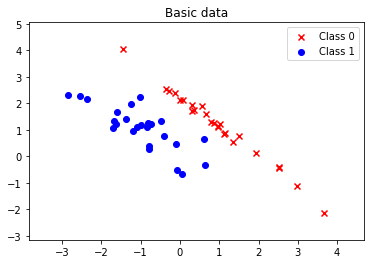

In [5]:
x_N, y_N = make_classification(n_samples=50, n_features=2, n_redundant=0, 
                               n_clusters_per_class=1, class_sep=1)
plot_data(x_N, y_N)

In [6]:
model = LogisticRegression()
model.fit(x_N, y_N)

LogisticRegression()

#### Sample outputs
We can see that, for a random selection of 5 data points, the `predict()` function gives output that is in the form of the usual discrete class label (0/1).  This class is derived from the output of the logistic itself, which can be obtained directly using `predict_proba()`.  Label predictions are chosen based upon the class that gets the highest probability, which means that we are using a threshold of $0.5$ on binary-class data.

In [7]:
rng = default_rng()
sample_data = rng.choice(x_N, 5)
sample_data

array([[-0.798,  0.399],
       [-0.981,  1.16 ],
       [ 1.927,  0.12 ],
       [-1.669,  1.326],
       [ 0.864,  1.246]])

In [8]:
model.predict(sample_data)

array([1, 1, 0, 1, 0])

In [9]:
model.predict_proba(sample_data)

array([[0.033, 0.967],
       [0.077, 0.923],
       [0.939, 0.061],
       [0.021, 0.979],
       [0.894, 0.106]])

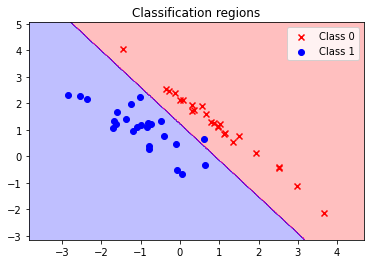

In [10]:
plot_model_prediction(model, x_N, y_N)

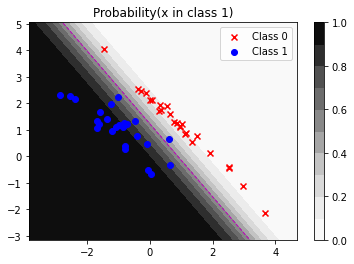

In [11]:
plot_model_contour(model, x_N, y_N)

#### Basic model metrics

We can compute a number of metrics of model performance, either using the model itself, or using its predictions and outside functions.

In [12]:
y_pred = model.predict(x_N)
y_prob = model.predict_proba(x_N)

In [13]:
# Metric 1: this is based solely upon basic accuracy 
# (fraction of correct outputs from the predict() function).
model.score(x_N, y_N)

0.98

In [14]:
# Metric 2: we can also see what the logistic loss is; this is what
# the model algorithms seek to minimize, but is generally pretty meaningless
# to us, except that (a) if we compare two models on the same data, lower
# numbers are better, and (b) if logistic loss is 0, we have the best possible result.
log_loss(y_N, y_prob)

0.12590667853708998

In [15]:
# ERROR ERROR ERROR!!!
# A common mistake is to use the output of predict() and then compute logistic loss.
# This is always too high—it treats every prediction as an extreme probability, and
# means that every element that is incorrect gives maximum loss, whereas properly 
# measured logistic loss treats numbers that are closer to what they should be as
# generating less loss, even if the prediction threshold misclassifies them per se.
log_loss(y_N, y_pred)

0.6907755278982145

#### ROC curve metrics
We can use the `roc_curve()` and `roc_auc_score()` functions to see how the model does across various possible thresholds.  If we want to set our threshold for classification to achieve a different TPR/FPR trade-off (or something else), we can simply use `predict_proba()` and then write our own simple version of `predict()` that assigns discrete classes based upon whatever
threshold we like.

In the code below, `fpr`, `tpr`, and `thresholds` are returned as lists of the various T/F positive rates, relative to different possible thresholds for classification.

**However**: be aware that interpreting the `thresholds` value requires some care.  In particular, it will usually contain some value(s) greater than $1.0$ (which, obviously, can't be treated as a probability threshold directly).  Read the documentation to see what's going on there, and do some research if you're trying to use these numbers as probability thresholds to make sure you know what is going on.

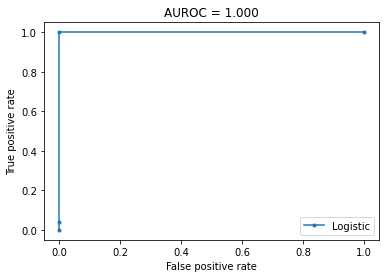

In [16]:
# Note: with only a few data points, mostly the ROC curve is going to be pretty boring,
# in the sense that it won't have many points, or is even "perfect" (with area = 1.0).
# If you go back to the start of all this code, and make the data-set size larger in 
# the make_classification() function, you will get more interesting results.
probs_class1 = y_prob[:,1]
auroc = roc_auc_score(y_N, probs_class1)
fpr, tpr, thresholds = roc_curve(y_N, probs_class1)
plt.plot(fpr, tpr, marker='.', label='Logistic')
plt.title('AUROC = %.3f' % auroc)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend();

In [17]:
for i in range(len(fpr)):
    print("Threshold: %f, TPR: %f, FPR: %f" % (thresholds[i], tpr[i], fpr[i]))

Threshold: 1.993124, TPR: 0.000000, FPR: 0.000000
Threshold: 0.993124, TPR: 0.040000, FPR: 0.000000
Threshold: 0.380836, TPR: 1.000000, FPR: 0.000000
Threshold: 0.037355, TPR: 1.000000, FPR: 1.000000


### A built-in test data-set of digit images
We can use `load_digits()` to use a pre-defined set of about 1,800 low-resolution images of the digits $0, 1, \ldots, 9$.  Each of these images consists of 64 grayscale pixel values, rolled out into a single vector of values, like all input data.  We can reshape and display the data as an $(8 \times 8)$ image if we like, but when we feed it into models it needs to be in its usual one-dimensional $\mathbf{x}$-vector form.

In [18]:
digits = load_digits()
print("Data shape: ", digits.data.shape)

Data shape:  (1797, 64)


In [19]:
indices = rng.choice(digits.data.shape[0], 5)
random_data = digits.data[indices]
random_data_labels = digits.target[indices]

# Here's a single random data point, as stored in input/label form
print("Data input: ", random_data[0])
print("Data label: ", random_data_labels[0])

Data input:  [ 0.  0.  0. 11. 16.  3.  0.  0.  0.  0.  5. 16. 16.  5.  0.  0.  0.  6.
 16. 15. 16.  3.  0.  0.  0. 11. 11. 10. 16.  1.  0.  0.  0.  0.  0. 10.
 15.  0.  0.  0.  0.  0.  0. 11. 13.  0.  0.  0.  0.  0.  0. 10. 16.  2.
  0.  0.  0.  0.  0.  7. 16.  2.  0.  0.]
Data label:  1


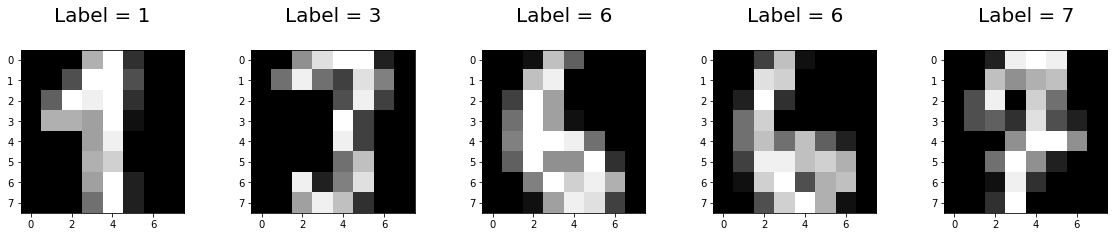

In [20]:
# Here are 5 such random data points, reshaped and displayed as images
plt.figure(figsize=(20, 3))
for index, (img, out) in enumerate(zip(random_data, random_data_labels)):
    plt.subplot(1, 5, index + 1)
    plt.imshow(np.reshape(img, (8,8)), cmap=plt.cm.gray)
    plt.title('Label = %i\n' % out, fontsize=20)

#### Using logistic regression with multi-class ($k > 2$) data
Since the logistic model just assigns probability-like values, summing to $1.0$, it can easily handle multi-class data.  Again, if you use the `predict()` function, it will just generate the probability-values using `predict_proba()` and then assign each data point to the class that has the largest such value.  (The implicit threshold for classification is thus more complicated to work out, since it really depends upon all the labels.)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(digits.data, digits.target, test_size=0.2)
model = LogisticRegression(max_iter=10_000)
model.fit(x_train, y_train)
predictions = model.predict(x_test)
score = model.score(x_test, y_test)
print("Basic accuracy: ", score)

#### Confusion matrices
The `confusion_matrix()` function will generate results for multi-class data, too.  In this case, it has 10 rows and columns, one each for predicted label and actual label, both from $[0,9]$.

In [ ]:
conf_matrix = confusion_matrix(y_test, predictions)
print(conf_matrix)

In [ ]:
# The basic CM isn't very pretty, but we can jazz it up with some plotting.
plt.figure(figsize=(9, 9))
sns.heatmap(conf_matrix, annot=True, linewidths=0.5, cmap='Reds')
plt.ylabel('Actual digit')
plt.xlabel('Predicted digit')
plt.title('Confusion matrix')

In [ ]:
# Here, we can see examples of 5 of the data-points that the model gets wrong.  
# (This assumes there are at least 5; if not, might need to modify code a bit.)
wrong = np.nonzero(predictions != y_test)[0]

plt.figure(figsize=(20, 3))
for plotIdx, wrongIdx in enumerate(wrong[0:5]):
    plt.subplot(1, 5, plotIdx + 1)
    plt.imshow(np.reshape(x_test[wrongIdx], (8,8)), cmap=plt.cm.gray)
    plt.title('Predicted: {}, Actual: {}'.format(predictions[wrongIdx],
             y_test[wrongIdx]))